In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from collections import Counter
import math, random

In [2]:
def normal_cdf(x, mu=0,sigma=1):
    return (1 + math.erf((x - mu) / math.sqrt(2) / sigma)) / 2

def inverse_normal_cdf(p, mu=0, sigma=1, tolerance=0.00001):
    """find approximate inverse using binary search"""

    # if not standard, compute standard and rescale
    if mu != 0 or sigma != 1:
        return mu + sigma * inverse_normal_cdf(p, tolerance=tolerance)

    low_z, low_p = -10.0, 0            # normal_cdf(-10) is (very close to) 0
    hi_z,  hi_p  =  10.0, 1            # normal_cdf(10)  is (very close to) 1
    while hi_z - low_z > tolerance:
        mid_z = (low_z + hi_z) / 2     # consider the midpoint
        mid_p = normal_cdf(mid_z)      # and the cdf's value there
        if mid_p < p:
            # midpoint is still too low, search above it
            low_z, low_p = mid_z, mid_p
        elif mid_p > p:
            # midpoint is still too high, search below it
            hi_z, hi_p = mid_z, mid_p
        else:
            break

    return mid_z

## 7.1 統計假設檢驗
就是H0與H1，並且否定H0  

## 7.2 丟硬幣

In [3]:
def normal_approximation_to_binomial(n, p):
    """finds mu and sigma corresponding to a Binomial(n, p)"""
    mu = p * n
    sigma = math.sqrt(p * (1 - p) * n)
    return mu, sigma

In [4]:
#####
#
# probabilities a normal lies in an interval
#
######

# the normal cdf _is_ the probability the variable is below a threshold
normal_probability_below = normal_cdf

# it's above the threshold if it's not below the threshold
def normal_probability_above(lo, mu=0, sigma=1):
    return 1 - normal_cdf(lo, mu, sigma)

# it's between if it's less than hi, but not less than lo
def normal_probability_between(lo, hi, mu=0, sigma=1):
    return normal_cdf(hi, mu, sigma) - normal_cdf(lo, mu, sigma)

# it's outside if it's not between
def normal_probability_outside(lo, hi, mu=0, sigma=1):
    return 1 - normal_probability_between(lo, hi, mu, sigma)

In [5]:
######
#
#  normal bounds
#
######


def normal_upper_bound(probability, mu=0, sigma=1):
    """returns the z for which P(Z <= z) = probability"""
    return inverse_normal_cdf(probability, mu, sigma)

def normal_lower_bound(probability, mu=0, sigma=1):
    """returns the z for which P(Z >= z) = probability"""
    return inverse_normal_cdf(1 - probability, mu, sigma)

def normal_two_sided_bounds(probability, mu=0, sigma=1):
    """returns the symmetric (about the mean) bounds
    that contain the specified probability"""
    tail_probability = (1 - probability) / 2

    # upper bound should have tail_probability above it
    upper_bound = normal_lower_bound(tail_probability, mu, sigma)

    # lower bound should have tail_probability below it
    lower_bound = normal_upper_bound(tail_probability, mu, sigma)

    return lower_bound, upper_bound

In [6]:
mu_0, sigma_0 = normal_approximation_to_binomial(1000, 0.5)
print("95% bounds based on assumption p is 0.5")
print("mu_0", mu_0)
print("sigma_0", sigma_0)
print("normal_two_sided_bounds(0.95, mu_0, sigma_0)", normal_two_sided_bounds(0.95, mu_0, sigma_0))

95% bounds based on assumption p is 0.5
mu_0 500.0
sigma_0 15.811388300841896
normal_two_sided_bounds(0.95, mu_0, sigma_0) (469.01026640487555, 530.9897335951244)


In [7]:
def two_sided_p_value(x, mu=0, sigma=1):
    if x >= mu:
        # if x is greater than the mean, the tail is above x
        return 2 * normal_probability_above(x, mu, sigma)
    else:
        # if x is less than the mean, the tail is below x
        return 2 * normal_probability_below(x, mu, sigma)

def count_extreme_values():
    extreme_value_count = 0
    for _ in range(100000):
        num_heads = sum(1 if random.random() < 0.5 else 0    # count # of heads
                        for _ in range(1000))                # in 1000 flips
        if num_heads >= 530 or num_heads <= 470:             # and count how often
            extreme_value_count += 1                         # the # is 'extreme'

    return extreme_value_count / 100000

upper_p_value = normal_probability_above
lower_p_value = normal_probability_below

In [8]:
print("power of a test")
print("95% bounds based on assumption p is 0.5")

lo, hi = normal_two_sided_bounds(0.95, mu_0, sigma_0)
print("lo", lo)
print("hi", hi)

print("actual mu and sigma based on p = 0.55")
mu_1, sigma_1 = normal_approximation_to_binomial(1000, 0.55)
print("mu_1", mu_1)
print("sigma_1", sigma_1)

# a type 2 error means we fail to reject the null hypothesis
# which will happen when X is still in our original interval
type_2_probability = normal_probability_between(lo, hi, mu_1, sigma_1)
power = 1 - type_2_probability # 0.887

print("type 2 probability", type_2_probability)
print("power", power)
print



power of a test
95% bounds based on assumption p is 0.5
lo 469.01026640487555
hi 530.9897335951244
actual mu and sigma based on p = 0.55
mu_1 550.0
sigma_1 15.732132722552274
type 2 probability 0.11345199870463285
power 0.8865480012953671


<function print>

In [9]:
print("one-sided test")
hi = normal_upper_bound(0.95, mu_0, sigma_0)
print("hi", hi) # is 526 (< 531, since we need more probability in the upper tail)
type_2_probability = normal_probability_below(hi, mu_1, sigma_1)
power = 1 - type_2_probability # = 0.936
print("type 2 probability", type_2_probability)
print("power", power)
print()

print("two_sided_p_value(529.5, mu_0, sigma_0)", two_sided_p_value(529.5, mu_0, sigma_0))

print("two_sided_p_value(531.5, mu_0, sigma_0)", two_sided_p_value(531.5, mu_0, sigma_0))

print("upper_p_value(525, mu_0, sigma_0)", upper_p_value(525, mu_0, sigma_0))
print("upper_p_value(527, mu_0, sigma_0)", upper_p_value(527, mu_0, sigma_0))
print()

one-sided test
hi 526.0073585242053
type 2 probability 0.06362051966928273
power 0.9363794803307173

two_sided_p_value(529.5, mu_0, sigma_0) 0.06207721579598857
two_sided_p_value(531.5, mu_0, sigma_0) 0.046345287837786575
upper_p_value(525, mu_0, sigma_0) 0.056923149003329065
upper_p_value(527, mu_0, sigma_0) 0.04385251499101195



## 7.3 置信區間

In [10]:
p_hat = 525 / 1000 
mu = p_hat 
sigma = math.sqrt(p_hat * (1 - p_hat) / 1000)   # 0.0158

interval =normal_two_sided_bounds(0.95, mu, sigma)        # [0.4940, 0.5560]
print("p_hat:", p_hat)
print("mu:{0} sigma{1}".format(mu, sigma))
print("Confidence Intervals of P:", interval)
print()

p_hat = 540 / 1000 
mu = p_hat 
sigma = math.sqrt(p_hat * (1 - p_hat) / 1000) # 0.0158 
normal_two_sided_bounds(0.95, mu, sigma) # [0.5091, 0.5709]
print("p_hat:", p_hat)
print("mu:{0} sigma{1}".format(mu, sigma))
print("Confidence Intervals of P:", interval)

p_hat: 0.525
mu:0.525 sigma0.015791611697353755
Confidence Intervals of P: (0.4940490278129096, 0.5559509721870904)

p_hat: 0.54
mu:0.54 sigma0.015760710643876435
Confidence Intervals of P: (0.4940490278129096, 0.5559509721870904)


## 7.4 P-hacking

In [29]:
#
# P-hacking
#
##

def run_experiment():
    """flip a fair coin 1000 times, True = heads, False = tails"""
    return [random.random() < 0.5 for _ in range(1000)]

def reject_fairness(experiment):
    """using the 5% significance levels"""
    num_heads = len([flip for flip in experiment if flip])
    return num_heads < 469 or num_heads > 531

In [31]:
print("P-hacking")

random.seed(0)
experiments = [run_experiment() for _ in range(1000)]
num_rejections = len([experiment
                      for experiment in experiments
                      if reject_fairness(experiment)])

print(num_rejections, "rejections out of 1000")

P-hacking
46 rejections out of 1000


## 7.5 案例：運行A/B測試

In [15]:
##
#
# running an A/B test
#
##

def estimated_parameters(N, n):
    p = n / N
    sigma = math.sqrt(p * (1 - p) / N)
    return p, sigma

def a_b_test_statistic(N_A, n_A, N_B, n_B):
    p_A, sigma_A = estimated_parameters(N_A, n_A)
    p_B, sigma_B = estimated_parameters(N_B, n_B)
    return (p_B - p_A) / math.sqrt(sigma_A ** 2 + sigma_B ** 2)

In [32]:
print("A/B testing")
z = a_b_test_statistic(1000, 200, 1000, 180)
print("a_b_test_statistic(1000, 200, 1000, 180)", z)
print("p-value", two_sided_p_value(z))
z = a_b_test_statistic(1000, 200, 1000, 150)
print("a_b_test_statistic(1000, 200, 1000, 150)", z)
print("p-value", two_sided_p_value(z))

A/B testing
a_b_test_statistic(1000, 200, 1000, 180) -1.1403464899034472
p-value 0.254141976542236
a_b_test_statistic(1000, 200, 1000, 150) -2.948839123097944
p-value 0.003189699706216853


## 7.6 貝葉斯推斷

In [33]:
##
#
# Bayesian Inference
#
##

def B(alpha, beta):
    """a normalizing constant so that the total probability is 1"""
    return math.gamma(alpha) * math.gamma(beta) / math.gamma(alpha + beta)

def beta_pdf(x, alpha, beta):
    if x < 0 or x > 1:          # no weight outside of [0, 1]
        return 0
    return x ** (alpha - 1) * (1 - x) ** (beta - 1) / B(alpha, beta)

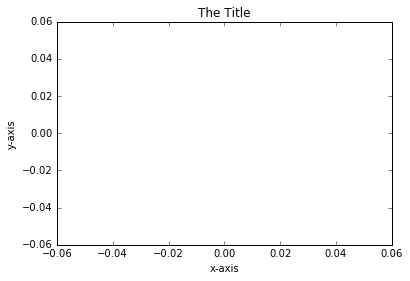

In [47]:
# 載入需要的...

import matplotlib.pyplot as plt
import numpy as np

# 準備數據 ... 假設我要畫一個sin波 從0~180度

x = np.arange(0,1)
y = np.sin(x * np.pi / 180.0)


# 開始畫圖

    # 設定要畫的的x,y數據list....

plt.plot(x,y) 

    # 設定圖的範圍, 不設的話，系統會自行決定
#plt.xlim(0,1)
#plt.ylim(0,10)
    # 照需要寫入x 軸和y軸的 label 以及title

plt.xlabel("x-axis") 
plt.ylabel("y-axis") 
plt.title("The Title") 


    # 在這個指令之前，都還在做畫圖的動作 
    # 這個指令算是 "秀圖" 
plt.show() 